In [10]:
import os
import csv
import json
import requests
from tqdm import tqdm
from statistics import mean
import matplotlib.pyplot as plt

In [15]:
stations = []
with open("all_processed.csv", "r") as data_file:
    result = list(csv.reader(data_file))
    for each_entry in result[1:]:
        stations.extend([[(each_entry[0], each_entry[1], each_entry[2], ),(float(each_entry[3]), float(each_entry[4])), (float(each_entry[5]), float(each_entry[6])), (float(each_entry[7]), float(each_entry[8])), (float(each_entry[9]), float(each_entry[10])), (float(each_entry[11]), float(each_entry[12]))]])
    data_file.close()

In [18]:
stations[0]

[('ALY', '69', '10'),
 (-73.6674676, 41.5933297),
 (-73.6720435, 41.571754399999996),
 (-73.6432174, 41.56833099999999),
 (-73.63863549999999, 41.58990599999999),
 (-73.6674676, 41.5933297)]

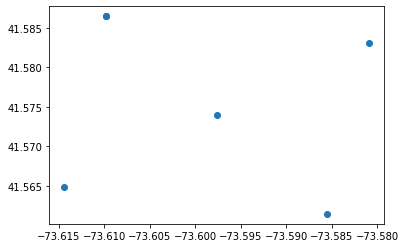

In [19]:
test_coordinate = stations[1][1:]
x_center = mean([test_coordinate[1][0], test_coordinate[3][0]])
y_center = mean([test_coordinate[0][1], test_coordinate[2][1]])
test_coordinate.append((x_center, y_center))
plt.scatter([i[0] for i in test_coordinate], [i[1] for i in test_coordinate])

## Get Grid points location data

In [48]:
stations = []
with open("all_processed.csv", "r") as data_file:
    result = list(csv.reader(data_file))
    for each_entry in result[1:]:
        stations.extend([[(each_entry[0], each_entry[1], each_entry[2], ),(float(each_entry[3]), float(each_entry[4])), (float(each_entry[5]), float(each_entry[6])), (float(each_entry[7]), float(each_entry[8])), (float(each_entry[9]), float(each_entry[10])), (float(each_entry[11]), float(each_entry[12]))]])
    data_file.close()

stations_info = {}
for each_station in tqdm(stations):
    station_name = "-".join(each_station[0])
    # coordinate locations
    station_coordinates = each_station[1:5]
    station_x_center = mean([station_coordinates[1][0], station_coordinates[3][0]])
    station_y_center = mean([station_coordinates[0][1], station_coordinates[2][1]])
    station_center = (station_x_center, station_y_center)
    # state and city name
    respond = requests.request("GET", f"https://api.weather.gov/points/{station_y_center},{station_x_center}")
    if respond.status_code == 200:
        if "properties" in respond.json().keys():
            if "city" in respond.json()["properties"]["relativeLocation"]["properties"].keys() and "state" in respond.json()["properties"]["relativeLocation"]["properties"].keys():
                city = respond.json()["properties"]["relativeLocation"]["properties"]["city"]
                state = respond.json()["properties"]["relativeLocation"]["properties"]["state"]
                # write information
                stations_info[station_name] = {
                    "coordinates": station_coordinates,
                    "center": station_center,
                    "relative_location": {
                        "city": city,
                        "state": state
                    }
                }
            else:
                stations_info[station_name] = {
                "coordinates": station_coordinates,
                "center": station_center,
                "relative_location": {
                    "city": "city not found",
                    "state": "state not found"
                }
            }    
        else:
            stations_info[station_name] = {
            "coordinates": station_coordinates,
            "center": station_center,
            "relative_location": {
                "city": "properties not found",
                "state": "properties not found"
            }
        }    
    else:
        stations_info[station_name] = {
            "coordinates": station_coordinates,
            "center": station_center,
            "relative_location": {
                "city": "request_failed",
                "state": "request_failed"
            }
        }

with open('data.json', 'w') as f:
    json.dump(stations_info, f)

100%|██████████| 18887/18887 [1:56:51<00:00,  2.69it/s]   


In [50]:
location_info = {}
with open("data.json", "r") as data_file:
    location_info = json.load(data_file)

request_failed = []
properties_not_found = []

for each_point in location_info.keys():
    city = location_info[each_point]["relative_location"]["city"]
    if city == "request_failed":
        request_failed.append(each_point)
    if city == "properties not found":
        properties_not_found.append(each_point)

43
0


In [56]:
proper_location = {}

for each_point in location_info.keys():
    if each_point not in request_failed:
        proper_location[each_point] = location_info[each_point]

coordinates = []

for each_point in proper_location.keys():
    coordinates.extend(proper_location[each_point]["coordinates"])

with open('proper_location.json', 'w') as f:
    json.dump(proper_location, f)

# Get weather information

In [79]:
test_location = list(proper_location.keys())[1]
test_location = test_location.split('-')
endpoint = f"https://api.weather.gov/gridpoints/{test_location[0]}/{test_location[1]},{test_location[2]}"
respond = requests.request("GET", endpoint)
respond.json()['properties']['temperature']['values'][0]['value']

21.666666666666668

In [88]:
test_data = {}

count = 0
for each_location in tqdm(list(proper_location.keys())[:100]):
    grid_point = each_location.split('-')
    endpoint = f"https://api.weather.gov/gridpoints/{grid_point[0]}/{grid_point[1]},{grid_point[2]}"
    respond = requests.request("GET", endpoint)
    if respond.status_code != 200:
        count += 1
    else:
        temperature = respond.json()['properties']['temperature']['values'][0]['value']

count

100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


26

ALY-88-14


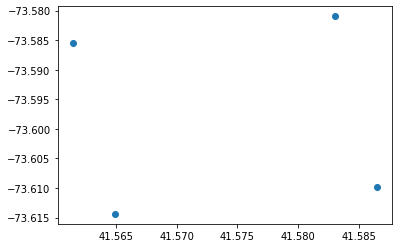

In [94]:
print(list(stations_info.keys())[20])
temp_info = stations_info[list(stations_info.keys())[1]]
plt.scatter([i[1] for i in temp_info["coordinates"]], [i[0] for i in temp_info["coordinates"]])
plt.show()